<a href="https://colab.research.google.com/github/GuillermoFidalgo/UA-EM-1/blob/main/Finite_elements.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Set 5 Solutions

PH - 531 E&M

Author:  Guillermo Fidlago


Use the finite element method described in Section 2.12 of Jackson’s textbook to find the potential inside a square of side $a$.
The potential at the top of the square is one volt $(V(x,y=a)=1$ Volt).
The potential on the other three sides is zero. There is no charge inside the square.
Compare your result with the exact result which you can obtain using separation of variables

For the analytical method we have to solve the Laplace Equation with Separation of Variables



$$ \nabla^2 V = 0 $$

\begin{equation*}
\frac{\partial^2 V}{ \partial x^2}  + \frac{\partial^2 V}{\partial y^2} = 0
\end{equation*}

If we assume a Solution of the form
$$
    X(x)Y(y) = V(x,y)
$$

we end with the following expression
$$
\underbrace{\frac{X''}{X}}_{\alpha^2} + \underbrace{\frac{Y''}{Y}}_{\beta^2}= 0
$$
This can only be true for two constant terms that add to zero and in this case $\alpha^2 = -\beta^2$.
Due to the symmetry of this problem we choose the following two second order ODE's.

\begin{gather*}
\frac{d^2 V}{d x^2} = -\alpha^2 X \to A\cos \alpha x + B \sin \alpha x \\
\frac{d^2 V}{d y^2} = \alpha^2 Y \to C e^{\alpha y} + D e^{-\alpha y}
\end{gather*}

Now we can solve the following equation with the boundary conditions.

\begin{gather*}
V(x,y) =  (A\cos \alpha x + B \sin \alpha x) (C e^{\alpha y} + D e^{-\alpha y})\\
V(0,y) = (A) (C e^{\alpha y} + D e^{-\alpha y}) = 0 \quad\to \quad A = 0\\
V(a,y) = B \sin \alpha x (C e^{\alpha y} + D e^{-\alpha y}) = 0 \quad\to \quad \alpha = \frac{n\pi}{a}\\
V(x,0) = B \sin\left(\frac{n\pi}{a}x \right) (C  + D ) = 0 \quad \to \quad C = -D
\end{gather*}

We now have
$$ V(x,y) = B\sin\left(\frac{n\pi}{a}x \right)\sinh\left(\frac{n\pi}{a}y \right) $$
Where I have absorbed the constant C into B. The General solution has to be a lienar combination of all n solutions.

$$ V(x,y) = \sum^\infty_{n=1} B_n \sin\left(\frac{n\pi}{a}x \right) \sinh\left(\frac{n\pi}{a}y \right)$$



To find the coefficients we identify this as a Fourier sine series and apply the last boundary condition here.

\begin{gather*}
V(x,y=a) = \sum^\infty_{n=1} B_n \sin\left(\frac{n\pi}{a}x \right) \sinh(n\pi) = 1\\
B_n \sinh(n\pi) = \frac2a \int_0^a (1) \sin \left(\frac{n\pi}{a}x \right) dx =
\begin{cases}
0 & \text{if $n$ is even}\\
\frac{4}{n\pi} & \text{if $n$ is odd}
\end{cases}
\end{gather*}

With this we now have our final expression for the potential.

$$ V(x,y) = \sum^\infty_{n\; \text{is odd}} \frac{4}{n\pi} \frac{\sin \left(\frac{n\pi}{a}x \right) \sinh \left( \frac{n\pi}{a}y \right) }{\sinh (n\pi) } $$

We can verrify this quickly by plotting our solution below.

In [1]:
import matplotlib.pyplot as plt
import numba as nb
import numpy as np

In [2]:
# This decorator allows the function to work with arrays, not just single scalars.
@nb.vectorize
def V(x, y, Nsquares=100):
    init = 0
    for i in range(1, Nsquares, 2):
        init += (
            4
            / (i * np.pi)
            / np.sinh(i * np.pi)
            * np.sin(i * np.pi * x / a)
            * np.sinh(i * np.pi * y / a)
        )
    return init

In [3]:
a = 1
N = 100
h = a / N
x = np.arange(0, a, h)
y = np.arange(0, a, h)
X, Y = np.meshgrid(x, y)


sol = V(X, Y, N)

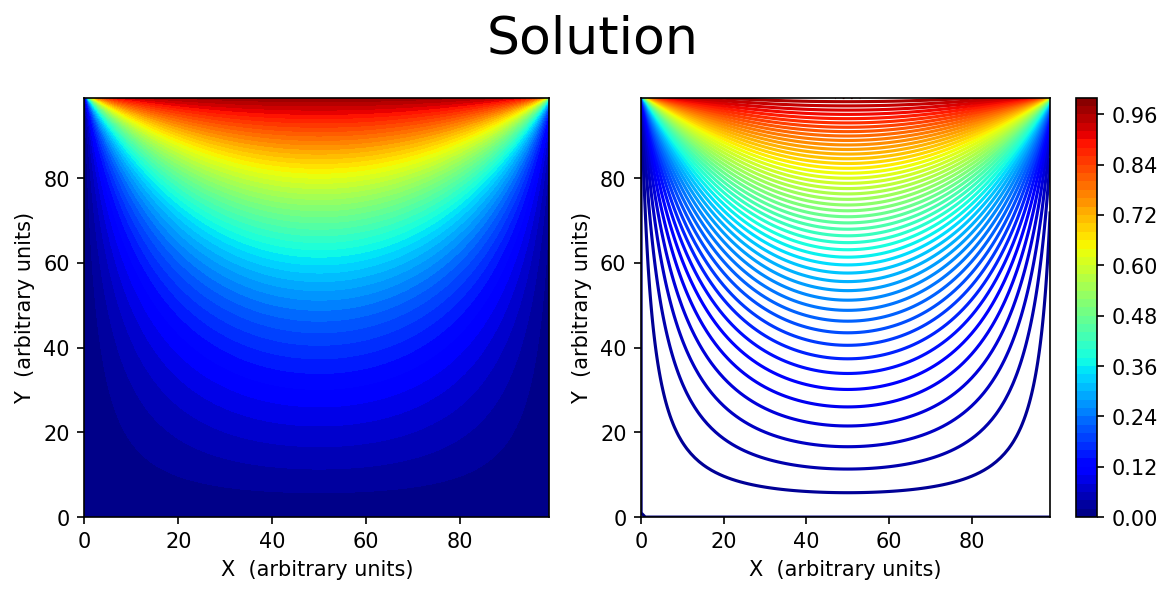

In [4]:
fig, ax = plt.subplots(1, 2, dpi=150, figsize=[8, 4], width_ratios=[1, 1.1])
cmap = "jet"
# img = ax[0].imshow(V(X, Y, N), cmap="jet", origin="lower")
img = ax[0].contourf(sol, 50, cmap=cmap)
ax[0].set_xlabel("X  (arbitrary units)")
ax[0].set_ylabel("Y  (arbitrary units)")

ax[1].contour(sol, 50, cmap=cmap)
ax[1].set_xlabel("X  (arbitrary units)")
ax[1].set_ylabel("Y  (arbitrary units)")
fig.colorbar(mappable=img, ax=ax[1])
fig.suptitle("Solution", size=25)
fig.tight_layout()

plt.show()

## Now for the Finite Elements method

The functions below are a set of trials and interpretations. Ultimately I'm not sure exactly how to implement the Galerkin method. 

In [5]:
# Defining the test function phi using the square element


@nb.vectorize
def phi(x, y, N=2):
    xi = yi = 0.1
    h = 1 / N
    if (abs(x - xi) > h) or (abs(y - yi) > h):
        return 0
    return (1 - abs(x - xi) / h) * (1 - abs(y - yi) / h)


# Define the Auxiliary coefficients of the potential for the Galerskin method
PSI = np.zeros([N, N], dtype=float)
PSI[-1, :] = 1  # the boundary condition

In [19]:
# TODO
def N(x, y):
    """
    Get the coefficients for the vertices of the triangle. It computes the
    area of a triangle with vertices given by (x,y) given by the determinant
    D of a system of equations.
    """
    D = np.linalg.det([[1, x[0], y[0]], [1, x[1], y[1]], [1, x[2], y[2]]])
    a = (x[1] * y[2] - x[2] * y[1]) / D
    b = (y[1] - y[2]) / D
    c = -(x[1] - x[3]) / D

    def h(x, y):
        return a * x + b * y + c

    b = [1, 0, 0]
    # A = a + b * x + c * y

    return h(x, y)

In [8]:
from scipy.integrate import quad


def galerkin_method(N):
    """Solves the 1D Poisson equation using Galerkin's method."""

    # Define basis functions
    def phi(i, x):
        if i == 0:
            return 1 - x
        if i == N:
            return x
        return (x >= (i - 1) / N) * (x <= i / N)

    # Construct the stiffness matrix and load vector
    A = np.zeros((N + 1, N + 1))
    b = np.zeros(N + 1)
    for i in range(N + 1):
        for j in range(N + 1):
            A[i, j] = quad(lambda x: phi(i, x) * phi(j, x), 0, 1)[0]
        b[i] = quad(lambda x: phi(i, x) * f(x), 0, 1)[0]

    # Solve the linear system

    return np.linalg.solve(A, b)


# Example usage
def f(x):
    return np.sin(np.pi * x)


N = 10  # Number of basis functions
u = galerkin_method(N)

print(u)

This last block of code is probably the closest thing to the Galerkin method, it was found online but to me it seems like a relaxation method.
The result looks a lot like my analytical result which shows promise of this method. 

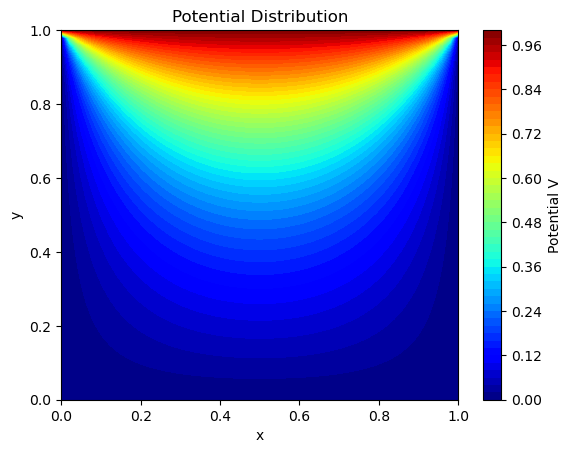

In [24]:
import scipy.sparse as sp
import scipy.sparse.linalg as spla

# Define the grid
N = 50  # Number of grid points in each direction
L = 1.0  # Length of the square domain
h = L / (N - 1)  # Grid spacing

# Create the grid points
x = np.linspace(0, L, N)
y = np.linspace(0, L, N)
X, Y = np.meshgrid(x, y)

# Initialize the potential array
V = np.zeros((N, N))

# Set boundary conditions
V[-1, :] = 1  # Top boundary at V=1

# Assemble the coefficient matrix and right-hand side vector
A = sp.lil_matrix((N * N, N * N))
b = np.zeros(N * N)

# Fill the matrix and vector
for i in range(1, N - 1):
    for j in range(1, N - 1):
        k = i * N + j
        A[k, k] = -4
        A[k, k - 1] = 1
        A[k, k + 1] = 1
        A[k, k - N] = 1
        A[k, k + N] = 1

# Apply boundary conditions
for i in range(N):
    for j in range(N):
        k = i * N + j
        if i == 0 or i == N - 1 or j == 0 or j == N - 1:
            A[k, :] = 0
            A[k, k] = 1
            b[k] = V[i, j]

# Solve the system of equations
A = A.tocsr()
V_flat = spla.spsolve(A, b)

# Reshape the solution to a 2D array
V = V_flat.reshape((N, N))


plt.contourf(X, Y, V, 50, cmap="jet")
plt.colorbar(label="Potential V")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Potential Distribution")
plt.show()